# Logrank with Imprint


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt

from imprint.nb_util import setup_nb
setup_nb()
import imprint as ip

In [2]:
# C++ code:
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/model/exponential/simple_log_rank.hpp
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/python/example/simple_log_rank.py
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/model/exponential/common/fixed_n_log_hazard_rate.hpp
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/stat/log_rank_test.hpp

In [3]:
# https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html#lifelines.statistics.multivariate_logrank_test
# https://en.wikipedia.org/wiki/Logrank_test
# https://web.stanford.edu/~lutian/coursepdf/unitweek3.pdf
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n0 = jnp.array([jnp.sum(~group), jnp.sum(group)])
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n0[:, None] - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)


In [4]:
import scipy.stats
import lifelines
from lifelines.statistics import multivariate_logrank_test

rvs = scipy.stats.expon.rvs(size=(10, 2))
control_rvs = rvs[:,0] 
hazard_ratio = 0.7
treatment_rvs = rvs[:,1] / hazard_ratio
all_rvs = np.concatenate([control_rvs, treatment_rvs])
group = np.concatenate([np.zeros(control_rvs.shape[0]), np.ones(treatment_rvs.shape[0])]).astype(bool)
ours = logrank_test(all_rvs, group, censoring_time=10000)
theirs = multivariate_logrank_test(all_rvs, group, t0=10000).test_statistic
ours**2, theirs

(DeviceArray(3.0007498, dtype=float32), 3.0007505870862126)

In [5]:
# Survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples = jax.random.exponential(self.key, shape=(max_K, n, 2))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = -theta[:, 0]
        treatment_hazard = -theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        sample_subset = self.samples[begin_sim:end_sim]
        group_subset = self.group[begin_sim:end_sim]

        control_rvs = jnp.tile(sample_subset[None, :, :, 0], (hazard_ratio.shape[0], 1, 1))
        treatment_rvs = sample_subset[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        test_stat = -self.vmap_logrank_test(
            all_rvs, group_subset, self.censoring_time
        )
        return test_stat

In [6]:
g = ip.cartesian_grid(
    [-2, -2], [-1, -1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")]
)
lr = LogRank(0, 200000, n=100, censoring_time=10000000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1675960795, n_bits=18, worker_bits=18) = [4490684420193517568, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=2, worker_id=1, t=1675960796, n_bits=18, worker_bits=18) = [4490684488912994304 4490684488912994305, ...]:


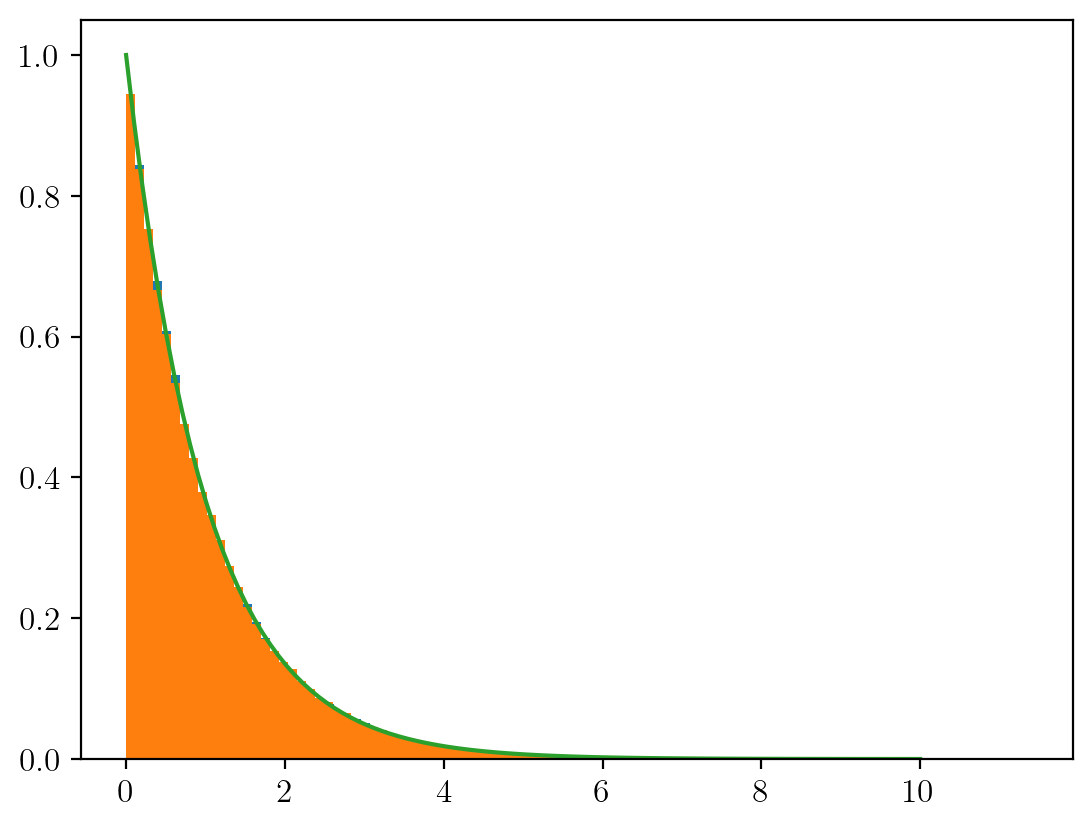

In [7]:
# plot lr.samples[:,0,0] and lr.samples[:,0,1] on the same plot
plt.figure()
plt.hist(lr.samples[:,0,0].ravel(), bins=100, density=True, label='control')
plt.hist(lr.samples[:,0,1].ravel(), bins=100, density=True, label='treatment')
# and compare to an exponential distribution with lambda = 1
x = jnp.linspace(0, 10, 100)
plt.plot(x, scipy.stats.expon.pdf(x), label="exponential")

plt.show()

The log rank test statistic should be asymptotically standard normal when the null hypothesis is true! But it's not...

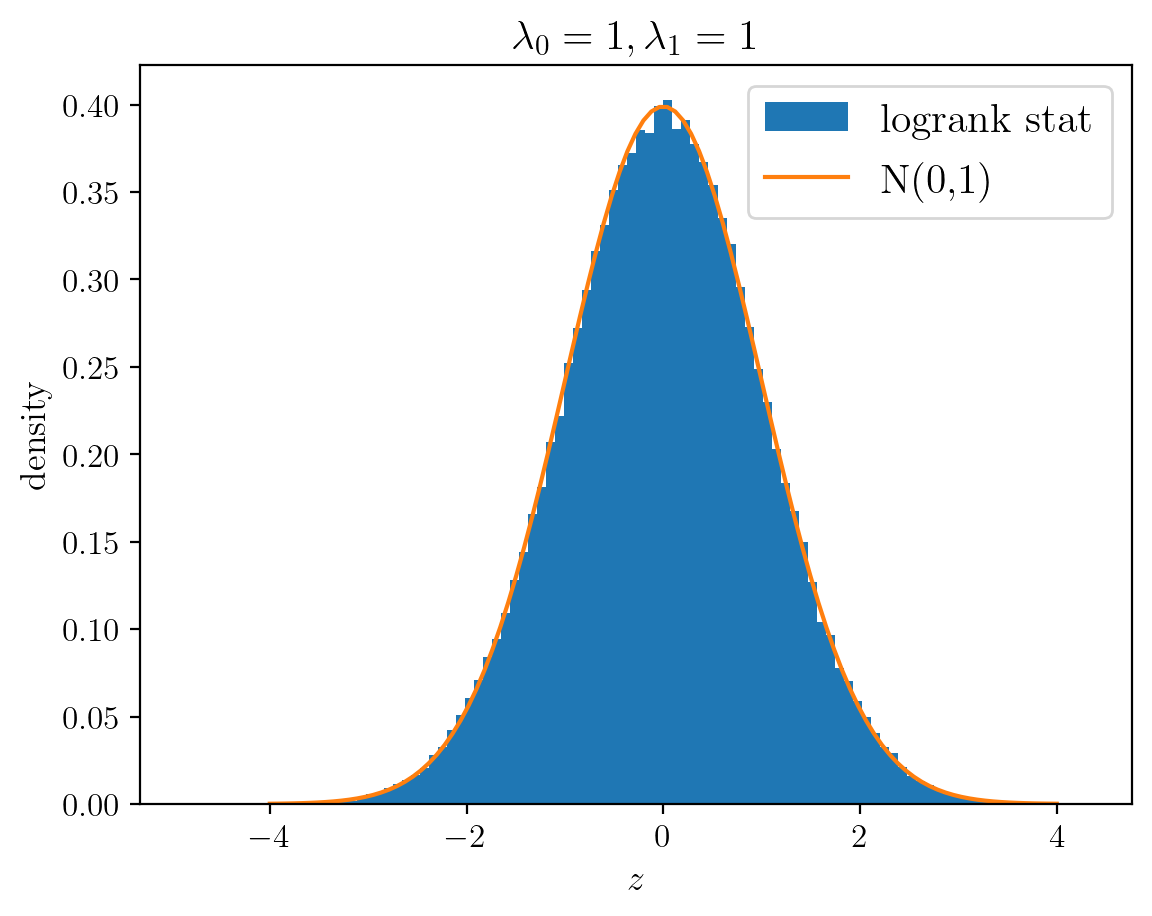

In [8]:
plt.title('$\lambda_0 = 1, \lambda_1 = 1$')
plt.hist(stats.flatten(), bins=100, density=True, label='logrank stat')
xs = np.linspace(-4, 4, 100)
plt.plot(xs, scipy.stats.norm.pdf(xs), label='N(0,1)')
plt.xlabel('$z$')
plt.ylabel('density')
plt.legend()
plt.show()

In [9]:
g = ip.cartesian_grid([-2, -2], [-0.5, -0.5], n=[20, 20], null_hypos=[ip.hypo("theta0 > theta1")])
rej_df = ip.validate(LogRank, g=g, lam=-1.96, model_kwargs=dict(n=10, censoring_time=12))
rej_df

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1675960806, n_bits=18, worker_bits=18) = [4490685176107761664 4490685176107761665 4490685176107761666, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40, worker_id=1, t=1675960807, n_bits=18, worker_bits=18) = [4490685244827238400 4490685244827238401 4490685244827238402, ...]:


,tie_sum,tie_est,tie_cp_bound,tie_bound,K
0,439,0.026794,0.029876,0.039328,16384
1,368,0.022461,0.025302,0.033773,16384
2,318,0.019409,0.022066,0.029853,16384
3,270,0.016479,0.018944,0.026026,16384
4,231,0.014099,0.016393,0.022894,16384
...,...,...,...,...,...
205,513,0.031311,0.034622,0.063310,16384
206,513,0.031311,0.034622,0.067028,16384
207,513,0.031311,0.034622,0.071811,16384
208,513,0.031311,0.034622,0.078174,16384


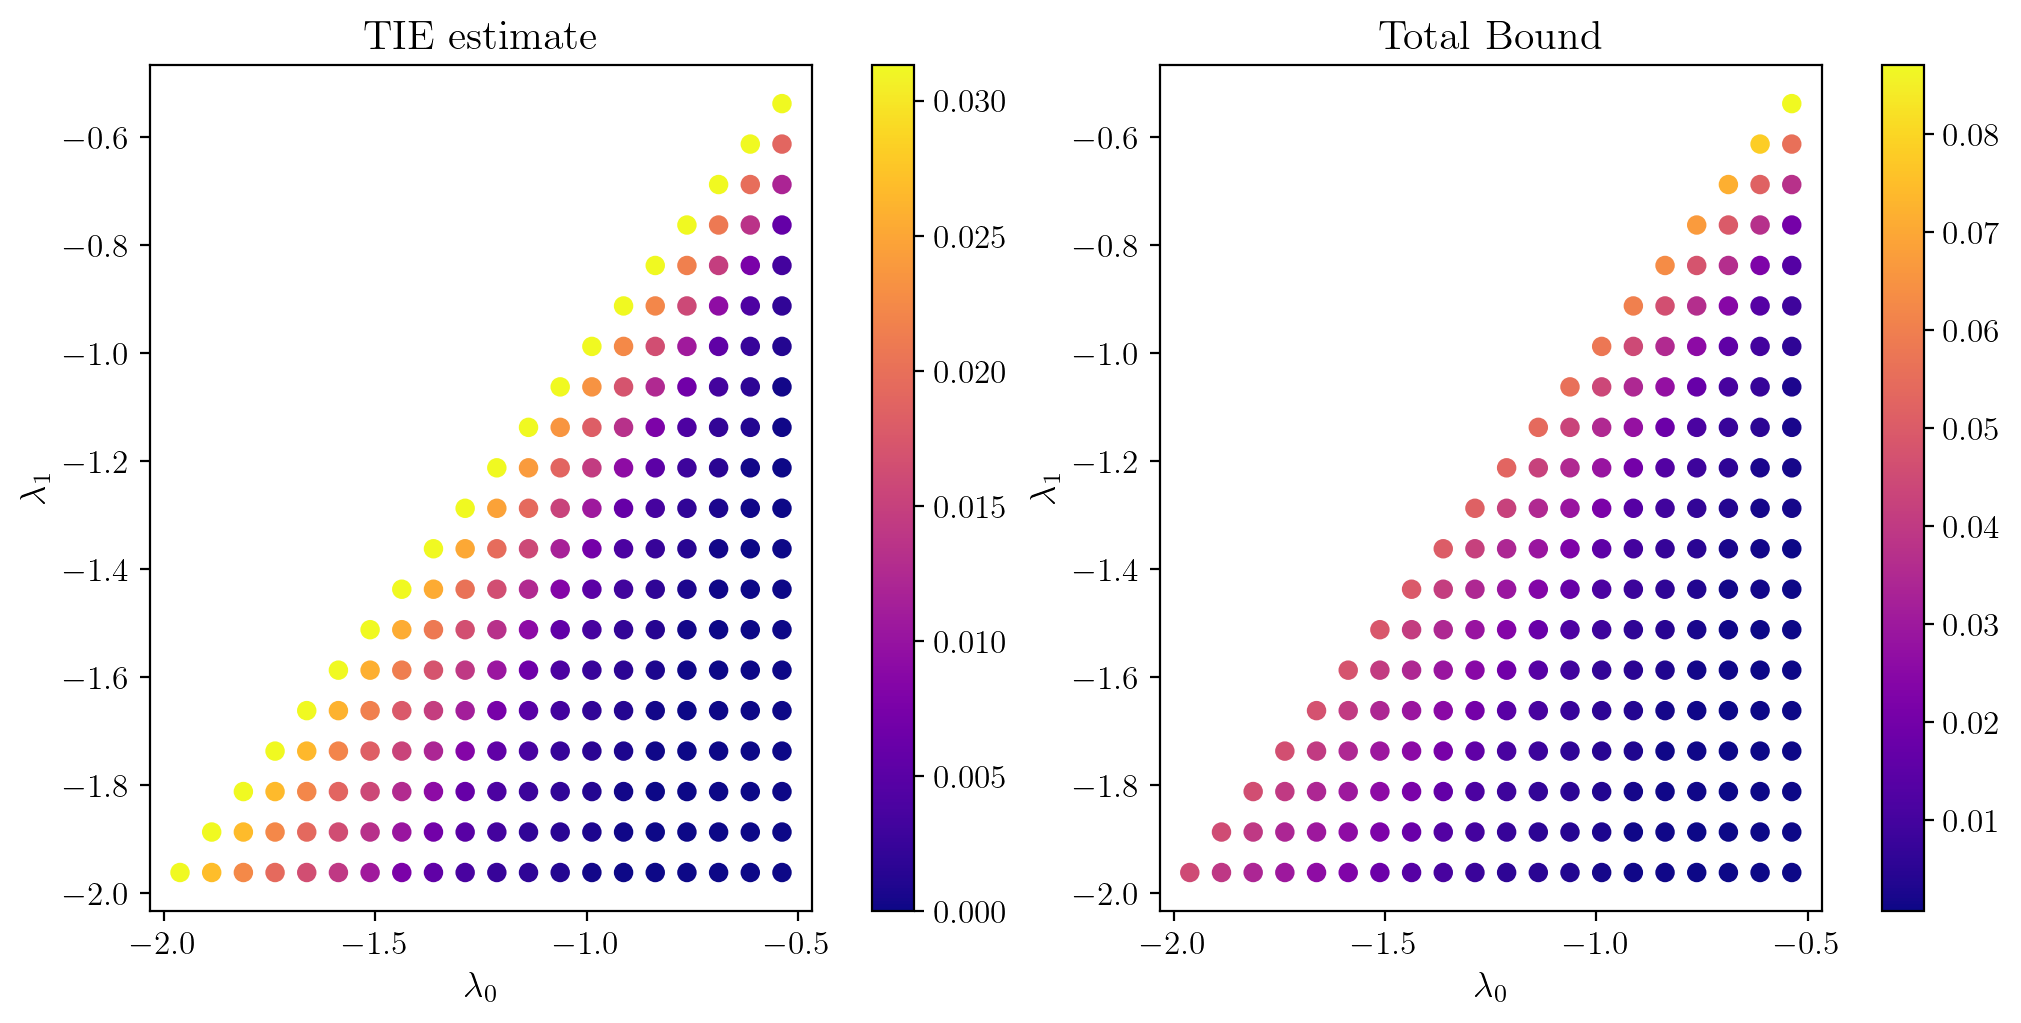

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), constrained_layout=True)
plt.subplot(1,2,1)
plt.title('TIE estimate')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Total Bound')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_bound'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.show()

In [35]:
g = ip.cartesian_grid([-10, -10], [-0.05, -0.05], n=[100, 100], null_hypos=[ip.hypo("theta0 > theta1")])

DEBUG:imprint.grid:[worker_id=2] 
_gen_short_uuids(n=10000, worker_id=1, t=1675973177, n_bits=18, worker_bits=18) = [4491535304754462720 4491535304754462721 4491535304754462722, ...]:
DEBUG:imprint.grid:[worker_id=2] 
_gen_short_uuids(n=222, worker_id=1, t=1675973178, n_bits=18, worker_bits=18) = [4491535373473939456 4491535373473939457 4491535373473939458, ...]:


In [42]:
import confirm.adagrid as ada
import confirm.cloud.clickhouse as ch
db = ch.Clickhouse.connect()
ada.ada_validate(
    LogRank,
    g=g,
    db=db,
    lam=-1.96,
    step_size=2**15,
    packet_size=2**10,
    model_kwargs=dict(n=10, censoring_time=12),
    backend=ada.ModalBackend(n_workers=4, gpu="T4")
)

INFO:confirm.cloud.clickhouse:[worker_id=2] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/None
INFO:confirm.cloud.clickhouse:[worker_id=2] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/f3cb585e7e974c429ddf906ec016af0d
INFO:confirm.cloud.clickhouse:[worker_id=2] 
Connected to job f3cb585e7e974c429ddf906ec016af0d
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set_or_append(config) -> False None
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set(config) -> False config
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
writing 5054 tiles
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set step info: (-1, 0, 0, 0)
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set(null_hypos) -> False null_hypos
DEBUG:confirm.adagrid.adagrid:first step (0, 0, 10, 5054) n_tiles=5054 packet_size=512
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set step info: (0, 0, 10, 5054)
INFO:confirm.adagrid.adagrid:Launching Modal job with 4 workers


2023-02-09T20:12:21+0000 Decrypting secrets. stdout from sops:
 
2023-02-09T20:12:21+0000 Environment variables loaded from /root/.env: ['CLICKHOUSE_HOST', 'CLICKHOUSE_TEST_HOST', 'CLICKHOUSE_PASSWORD', 'CLICKHOUSE_2_HOST', 'CLICKHOUSE_2_TEST_HOST', 'CLICKHOUSE_2_PASSWORD', 'REDIS_HOST', 'REDIS_PASSWORD', 'MODAL_TOKEN_ID', 'MODAL_TOKEN_SECRET']
2023-02-09T20:12:21+0000 Enabling 64-bit floats in JAX.
2023-02-09T20:12:21+0000 [worker_id=None] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/None
2023-02-09T20:12:21+0000 [worker_id=None] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/f3cb585e7e974c429ddf906ec016af0d
2023-02-09T20:12:21+0000 [worker_id=None] 
Connected to job f3cb585e7e974c429ddf906ec016af0d
2023-02-09T20:12:21+0000 [worker_id=3] 
get(config) -> True config
2023-02-09T20:12:21+0000 Decrypting secrets. stdout from sops:
 
2023-02-09T20:12:21+0000 Environment variables loaded from /root/.env: ['CLICKHOUSE_HOST', 'CLICKHOU

Clickhouse(connection_details={'host': 't2n4z83v82.us-east-1.aws.clickhouse.cloud', 'port': 8443, 'username': 'default', 'password': 'pxgBvuGnbiPG', 'database': 'f3cb585e7e974c429ddf906ec016af0d'}, client=<clickhouse_connect.driver.httpclient.HttpClient object at 0x2cfdeb9a0>, redis_con=Redis<ConnectionPool<Connection<host=us1-tolerant-leech-37085.upstash.io,port=37085,db=0>>>, job_id='f3cb585e7e974c429ddf906ec016af0d', _tiles_columns=Index(['id', 'active', 'parent_id', 'theta0', 'theta1', 'radii0', 'radii1',
       'null_truth0', 'K', 'step_id', 'step_iter', 'creator_id',
       'creation_time'],
      dtype='object'), _results_columns=None, _d=2, _results_table_exists=False)

In [46]:
reports = db.get_reports()
reports

,worker_iter,worker_id,waitings,runtime_wait_for_lock,step_id,step_iter,step_n_iter,step_n_tiles,runtime_get_work,work_extraction_time,n_processed,runtime_update_step_info,runtime_processing,status,runtime_full_iter,n_finished_tiles,converged,max_tie_est,next_tile_tie_est,next_tile_tie_bound,next_tile_sim_cost,next_tile_grid_cost,next_tile_total_cost,next_tile_K,next_tile_at_max_K,runtime_convergence_criterion,n_tiles,step_max_total_cost,step_max_grid_cost,step_max_sim_cost,runtime_select_tiles,n_refine,n_deepen,n_complete,n_new_tiles,new_K_distribution,runtime_new_step
0,0,3,0,0.001786,0,0,10,5054,0.012344,1.675974e+09,506.0,0.001638,2.225406,WORK,2.933196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,4,0,0.019769,0,1,10,5054,0.011148,1.675974e+09,506.0,0.036914,2.227516,WORK,2.716316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,0,0.001895,0,3,10,5054,0.011675,1.675974e+09,506.0,0.003263,0.268319,WORK,0.486830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,0,0.119115,0,5,10,5054,0.011578,1.675974e+09,505.0,0.020193,1.031267,WORK,1.358466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,3,0,0.003464,0,6,10,5054,0.011646,1.675974e+09,505.0,0.001675,1.042507,WORK,1.236822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,29,6,1,0.013376,14,0,1,249,0.008723,1.675974e+09,249.0,0.013465,3.135378,NEW_STEP,4.536632,1971.0,False,0.032639,0.032639,0.034727,0.001160,0.000929,0.002089,131072.0,True,0.123220,69.0,0.002089,0.000929,0.00116,0.118772,69.0,0.0,0.0,384.0,{'131072': 384},0.922461
133,33,5,4,0.001512,14,1,1,249,NaN,NaN,NaN,NaN,NaN,CONVERGED,6.146394,249.0,True,0.032639,0.029205,0.032638,0.002237,0.001196,0.003433,32768.0,False,0.563724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,37,4,4,0.845235,14,1,1,249,NaN,NaN,NaN,NaN,NaN,CONVERGED,6.060933,249.0,True,0.032639,0.029205,0.032638,0.002237,0.001196,0.003433,32768.0,False,0.140005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,30,6,0,1.132964,14,1,1,249,NaN,NaN,NaN,NaN,NaN,CONVERGED,1.249342,249.0,True,0.032639,0.029205,0.032638,0.002237,0.001196,0.003433,32768.0,False,0.074867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
total_runtime = (
    reports["work_extraction_time"].max() - reports["work_extraction_time"].min()
)
total_processing = reports["runtime_processing"].sum()
total_processing, total_runtime, total_processing / total_runtime

(574.8276917934418, 214.855459690094, 2.6754158010346547)

In [48]:
(reports['runtime_processing'].sum() / reports['runtime_full_iter'].sum(),
reports['runtime_get_work'].sum() / reports['runtime_full_iter'].sum(),
reports['runtime_convergence_criterion'].sum() / reports['runtime_full_iter'].sum(),
reports['runtime_new_step'].sum() / reports['runtime_full_iter'].sum())

(0.6754554344324372,
 0.004082168115935451,
 0.0038696418925950726,
 0.016648085284761548)

In [13]:
results_df = db.get_results()
df = ip.Grid(results_df, None).prune_inactive().df

In [14]:
df.shape

(7269, 25)

In [15]:
results_df['K'].sum() / 1e6

893.607936

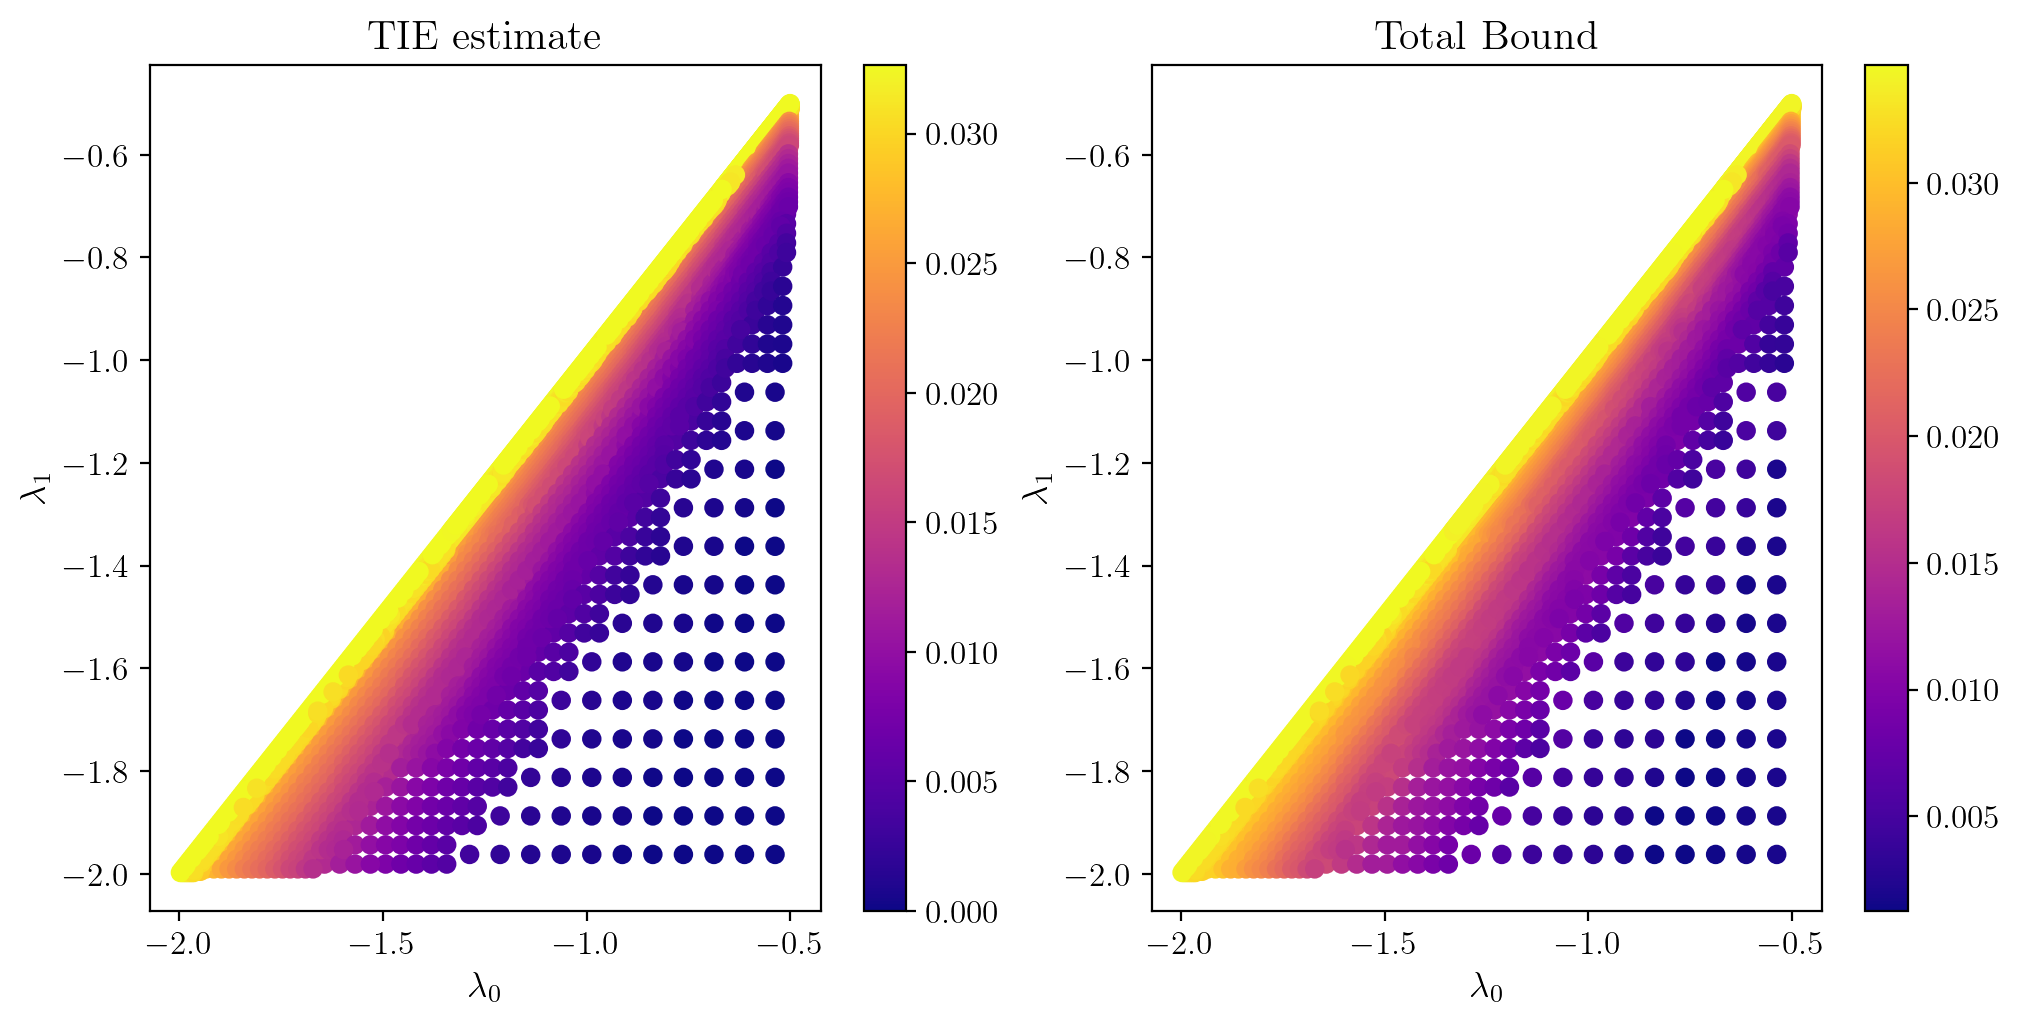

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), constrained_layout=True)
plt.subplot(1,2,1)
plt.title('TIE estimate')
plt.scatter(df['theta0'], df['theta1'], c=df['tie_est'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Total Bound')
plt.scatter(df['theta0'], df['theta1'], c=df['tie_bound'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.show()